<a href="https://colab.research.google.com/github/ianmazzu/ASL_HandSing/blob/main/HandSing_ASL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install split-folders

In [2]:
import os
import re
import os
import io

import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil
import re
import splitfolders

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, Input, concatenate
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import files

In [6]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Ruta al archivo zip en Google Drive
zip_path = '/content/dataset asl.zip'

# Extraer el archivo zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset/asl_dataset')

# Ruta base donde se extrajeron los archivos
base_path = '/content/dataset/asl_dataset'
# Diccionario para guardar nuestras 36 clases
categories = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9",
    10: "a", 11: "b", 12: "c", 13: "d", 14: "e", 15: "f", 16: "g", 17: "h", 18: "i", 19: "j",
    20: "k", 21: "l", 22: "m", 23: "n", 24: "o", 25: "p", 26: "q", 27: "r", 28: "s", 29: "t",
    30: "u", 31: "v", 32: "w", 33: "x", 34: "y", 35: "z",
}

def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(
        lambda x: x[re.search("_", x).start() + 1 : re.search("_", x).start() + 2]
        + "/"
        + x
    )
    return df

# Lista que contiene todos los nombres de archivos en el dataset
filenames_list = []
# Lista para almacenar la categoría correspondiente, nota que cada carpeta del dataset tiene una clase de datos
categories_list = []

for category in categories:
    # Add a forward slash to create the correct path
    filenames = os.listdir(os.path.join(base_path, categories[category]))
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({"filename": filenames_list, "category": categories_list})
df = add_class_name_prefix(df, "filename")

# Mezclar el dataframe
df = df.sample(frac=1).reset_index(drop=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df
df.head()

filename  category
0    t/hand4_t_bot_seg_1_cropped.jpeg        29
1  4/hand2_4_right_seg_3_cropped.jpeg         4
2    j/hand5_j_bot_seg_3_cropped.jpeg        19
3    k/hand2_k_bot_seg_4_cropped.jpeg        20
4  m/hand2_m_right_seg_3_cropped.jpeg        22

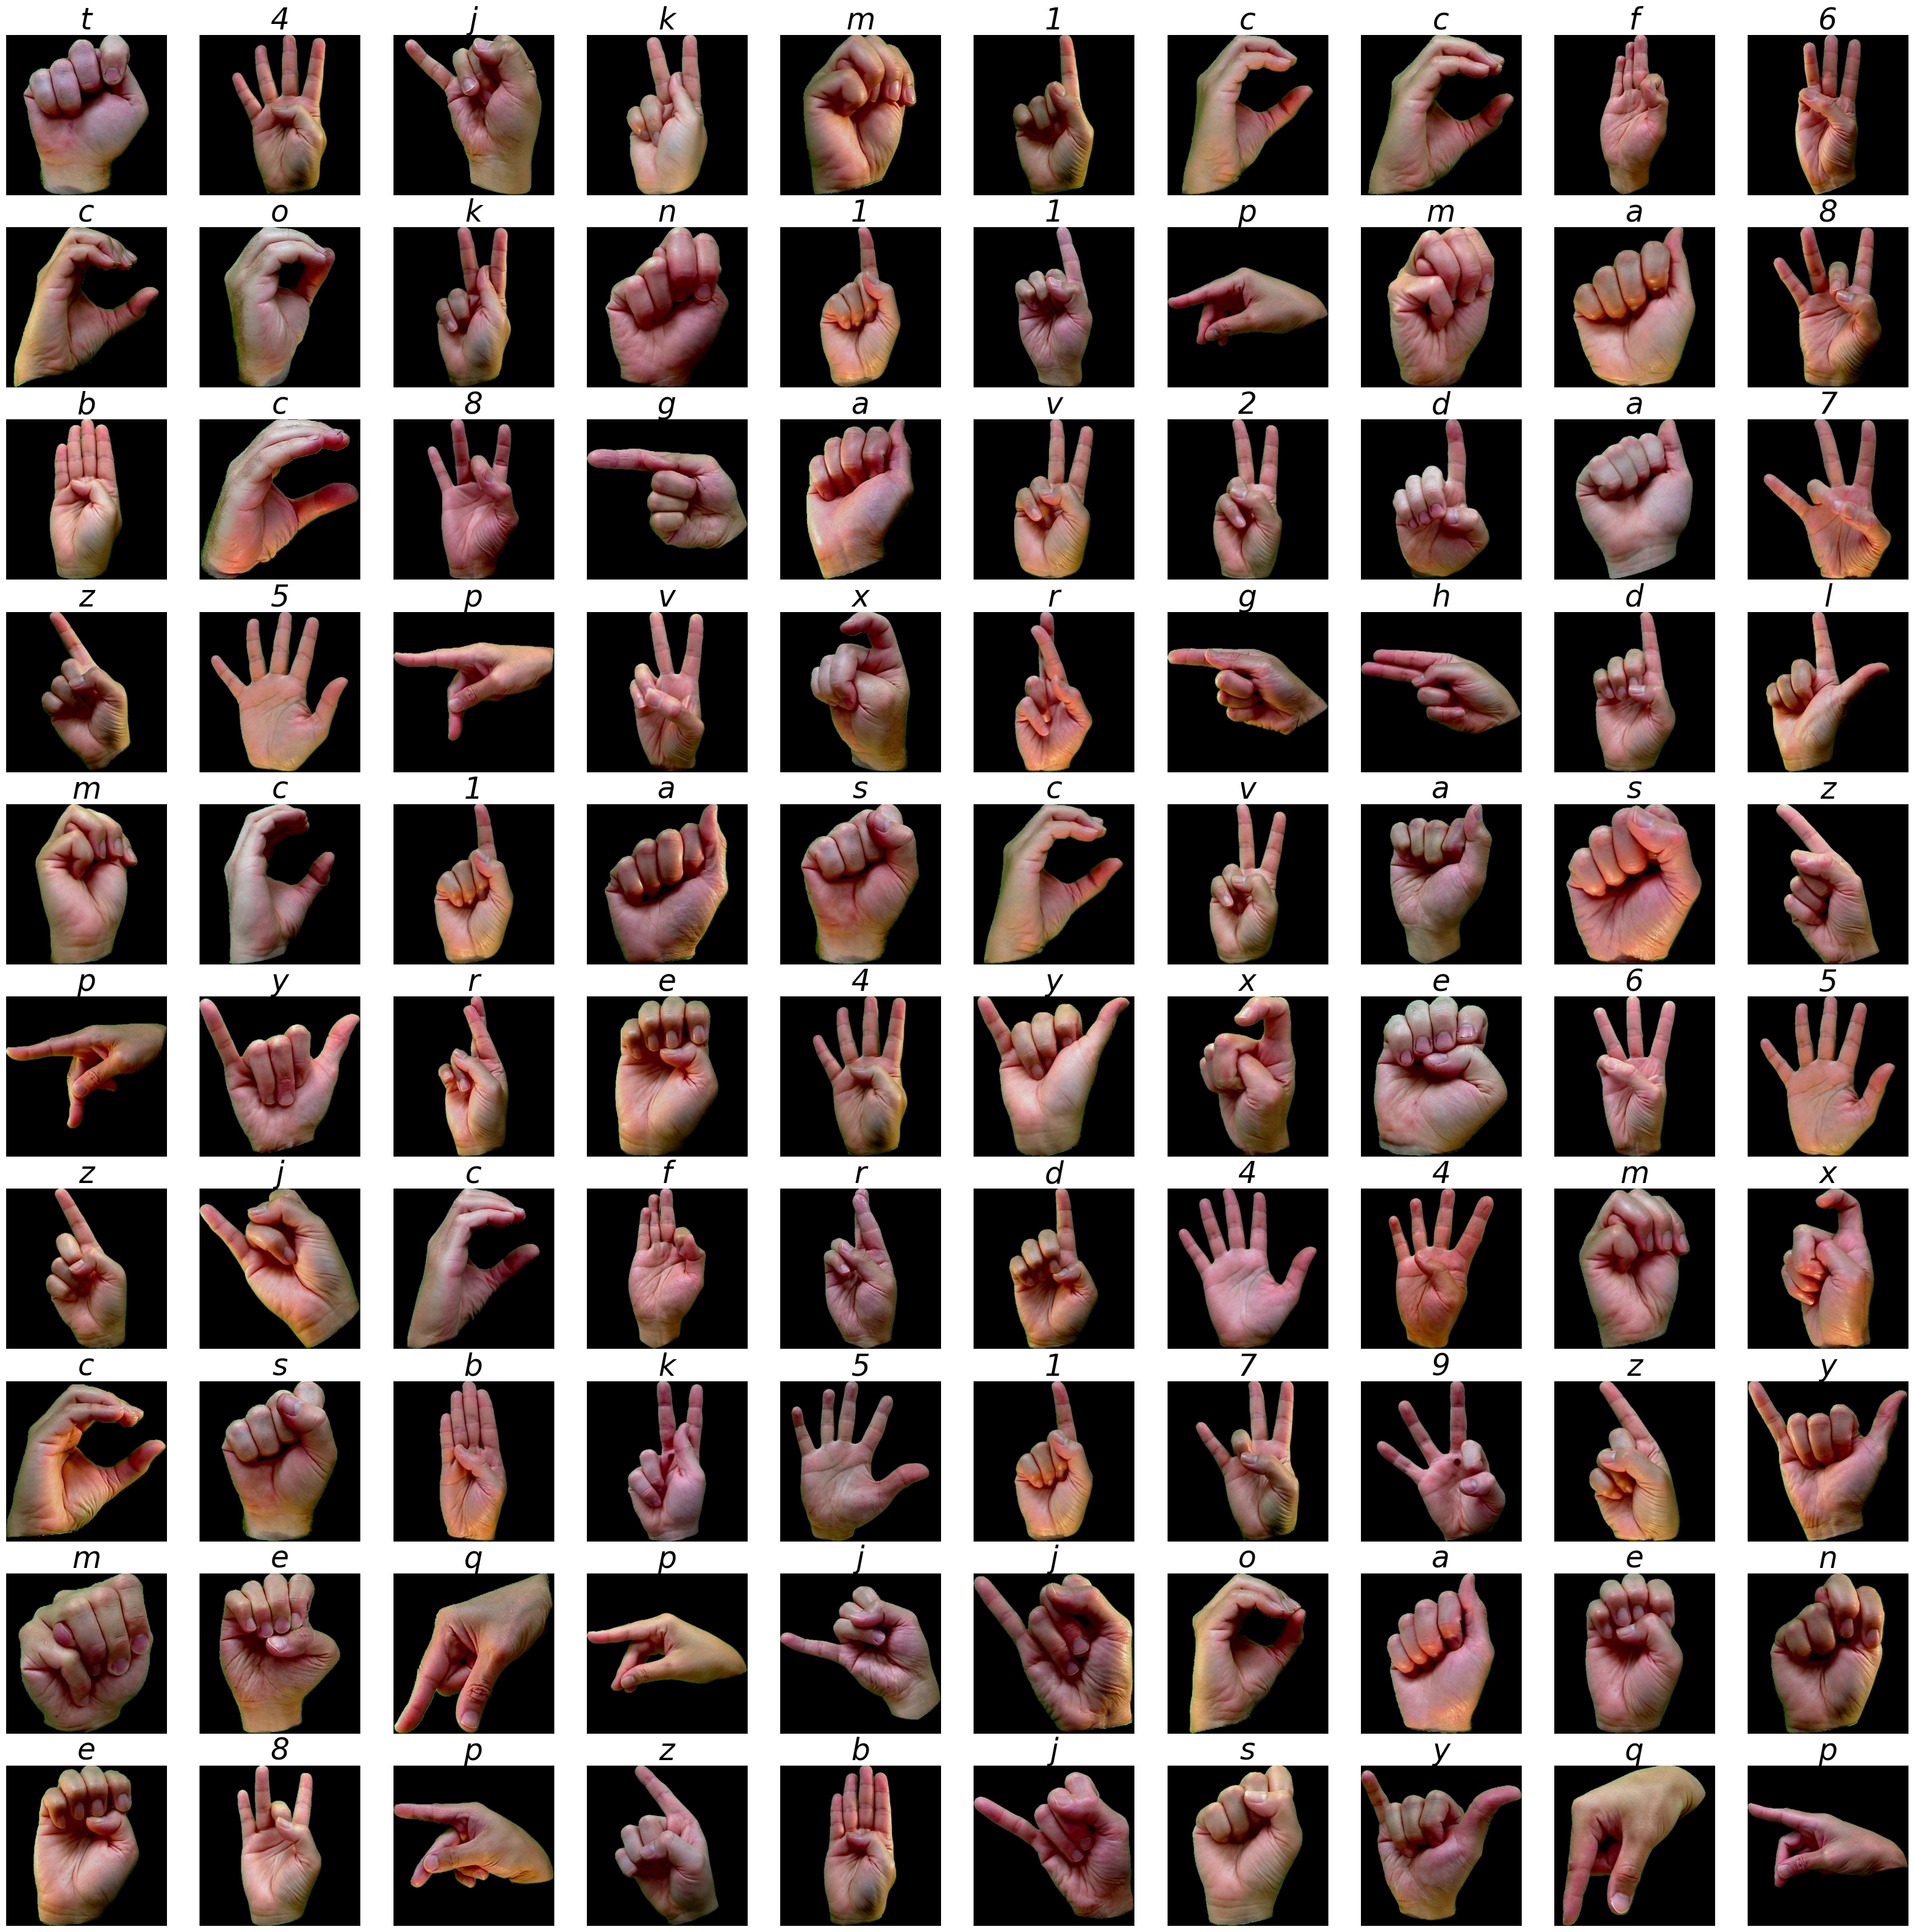

In [8]:
# Plot images
plt.figure(figsize=(40,40))

for i in range(100):
    path = os.path.join(base_path, df.filename[i])
    if os.path.exists(path):
        img = plt.imread(path)
        plt.subplot(10, 10, i + 1)
        plt.imshow(img)
        plt.title(categories[df.category[i]], fontsize=35, fontstyle='italic')
        plt.axis("off")
    else:
        print(f"El archivo {path} no existe.")

plt.show()

In [11]:
# Dividir los datos en entrenamiento y temporal (validación + prueba)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['category'], random_state=1333)

# Dividir el conjunto temporal en validación y prueba
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['category'], random_state=1333)


In [14]:
# Definir las rutas de salida
output_path = "/content/dataset/asl_dataset_split"
train_path = os.path.join(output_path, 'train')
val_path = os.path.join(output_path, 'val')
test_path = os.path.join(output_path, 'test')

# Crear directorios de salida
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

def move_files(df, base_path, output_path, categories):
    """
    Mueve los archivos de acuerdo con las categorías especificadas en el DataFrame.

    Args:
        df (pd.DataFrame): DataFrame con las columnas 'filename' y 'category'.
        base_path (str): Ruta base de los archivos.
        output_path (str): Ruta de destino para los archivos.
        categories (dict): Diccionario que mapea los valores numéricos de la categoría a las cadenas correspondientes.
    """
    for index, row in df.iterrows():
        category_num = row['category']
        category_str = str(category_num)

        # Limpieza del nombre de archivo
        filename = row['filename'].strip().replace('\r', '').replace('\n', '')

        # Construcción de rutas
        src_path = os.path.normpath(os.path.join(base_path, filename))
        dest_dir = os.path.normpath(os.path.join(output_path, categories[int(category_str)]))
        dest_path = os.path.normpath(os.path.join(dest_dir, os.path.basename(filename)))

        # Mostrar las rutas para depuración
        print(f"Origen: {src_path}, Destino: {dest_path}")

        # Crear el directorio de destino si no existe
        os.makedirs(dest_dir, exist_ok=True)

        # Verificar si el archivo existe antes de copiar
        if not os.path.exists(src_path):
            print(f"Advertencia: Archivo no encontrado en {src_path}")
            continue

        try:
            shutil.copy2(src_path, dest_path)
            print(f"Archivo copiado: {src_path} -> {dest_path}")
        except Exception as e:
            print(f"Error al copiar el archivo {src_path}: {e}")

# Suponiendo que train_df, val_df y test_df están definidos
# Llamar a la función con los argumentos correctos
move_files(train_df, base_path, train_path, categories)
move_files(val_df, base_path, val_path, categories)
move_files(test_df, base_path, test_path, categories)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Origen: /content/dataset/asl_dataset/w/hand2_w_right_seg_3_cropped.jpeg, Destino: /content/dataset/asl_dataset_split/train/w/hand2_w_right_seg_3_cropped.jpeg
Archivo copiado: /content/dataset/asl_dataset/w/hand2_w_right_seg_3_cropped.jpeg -> /content/dataset/asl_dataset_split/train/w/hand2_w_right_seg_3_cropped.jpeg
Origen: /content/dataset/asl_dataset/8/hand2_8_top_seg_5_cropped.jpeg, Destino: /content/dataset/asl_dataset_split/train/8/hand2_8_top_seg_5_cropped.jpeg
Archivo copiado: /content/dataset/asl_dataset/8/hand2_8_top_seg_5_cropped.jpeg -> /content/dataset/asl_dataset_split/train/8/hand2_8_top_seg_5_cropped.jpeg
Origen: /content/dataset/asl_dataset/3/hand1_3_top_seg_5_cropped.jpeg, Destino: /content/dataset/asl_dataset_split/train/3/hand1_3_top_seg_5_cropped.jpeg
Archivo copiado: /content/dataset/asl_dataset/3/hand1_3_top_seg_5_cropped.jpeg -> /content/dataset/asl_dataset_split/train/3/hand1_3_top_seg_5_cropped.

In [15]:
datagen = ImageDataGenerator(rescale= 1.0 / 255)
batch = 32
image_size = 200
img_channel = 3
n_classes = 36

train_data = datagen.flow_from_directory(directory= train_path,
                                         target_size=(image_size,image_size),
                                         batch_size = batch,
                                         class_mode='categorical')

val_data = datagen.flow_from_directory(directory= val_path,
                                       target_size=(image_size,image_size),
                                       batch_size = batch,
                                       class_mode='categorical',
                                       )

test_data = datagen.flow_from_directory(directory= test_path,
                                         target_size=(image_size,image_size),
                                         batch_size = batch,
                                         class_mode='categorical',
                                         shuffle= False)

Found 2012 images belonging to 36 classes.
Found 251 images belonging to 36 classes.
Found 252 images belonging to 36 classes.


In [16]:
model = Sequential()
# input layer
# Block 1
model.add(Conv2D(32,3,activation='relu',padding='same',input_shape = (image_size,image_size,img_channel)))
model.add(Conv2D(32,3,activation='relu',padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(64,3,activation='relu',padding='same'))
model.add(Conv2D(64,3,activation='relu',padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.3))

#Block 3
model.add(Conv2D(128,3,activation='relu',padding='same'))
model.add(Conv2D(128,3,activation='relu',padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.4))

# fully connected layer
model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(36, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 200, 200, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 200, 200, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 100, 100, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 80000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      40,960,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 36)                  │           4,644 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,317,828 (157.62 MB)

 Trainable params: 41,317,828 (157.62 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
early_stoping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience= 5,
                              restore_best_weights= True,
                              verbose = 0)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                         patience = 2,
                                         factor=0.5 ,
                                         verbose = 1)

In [18]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [19]:
asl_class = model.fit(train_data,
                      validation_data= val_data,
                      epochs=30,
                      callbacks=[early_stoping,reduce_learning_rate],
                      verbose = 1)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 446ms/step - accuracy: 0.1836 - loss: 3.0270 - val_accuracy: 0.7928 - val_loss: 0.6007 - learning_rate: 0.0010
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 117ms/step - accuracy: 0.7778 - loss: 0.6919 - val_accuracy: 0.8884 - val_loss: 0.2735 - learning_rate: 0.0010
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.9000 - loss: 0.3125 - val_accuracy: 0.9203 - val_loss: 0.2113 - learning_rate: 0.0010
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.9191 - loss: 0.2510 - val_accuracy: 0.9602 - val_loss: 0.1516 - learning_rate: 0.0010
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.9612 - loss: 0.1459 - val_accuracy: 0.9363 - val_loss: 0.2157 - learning_rate: 0.0010
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9578 - loss: 0.1232
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.9578 - loss: 0.1233 - val_accu

In [20]:
model.save('hand_sign_model.h5')

In [21]:
model.save('hand_sign_model.keras')

In [22]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_data , verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(val_data, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

The accuracy of the model for training data is: 99.90059733390808
The Loss of the model for training data is: 0.006003046873956919
The accuracy of the model for validation data is: 96.81274890899658
The Loss of the model for validation data is: 0.1393982321023941


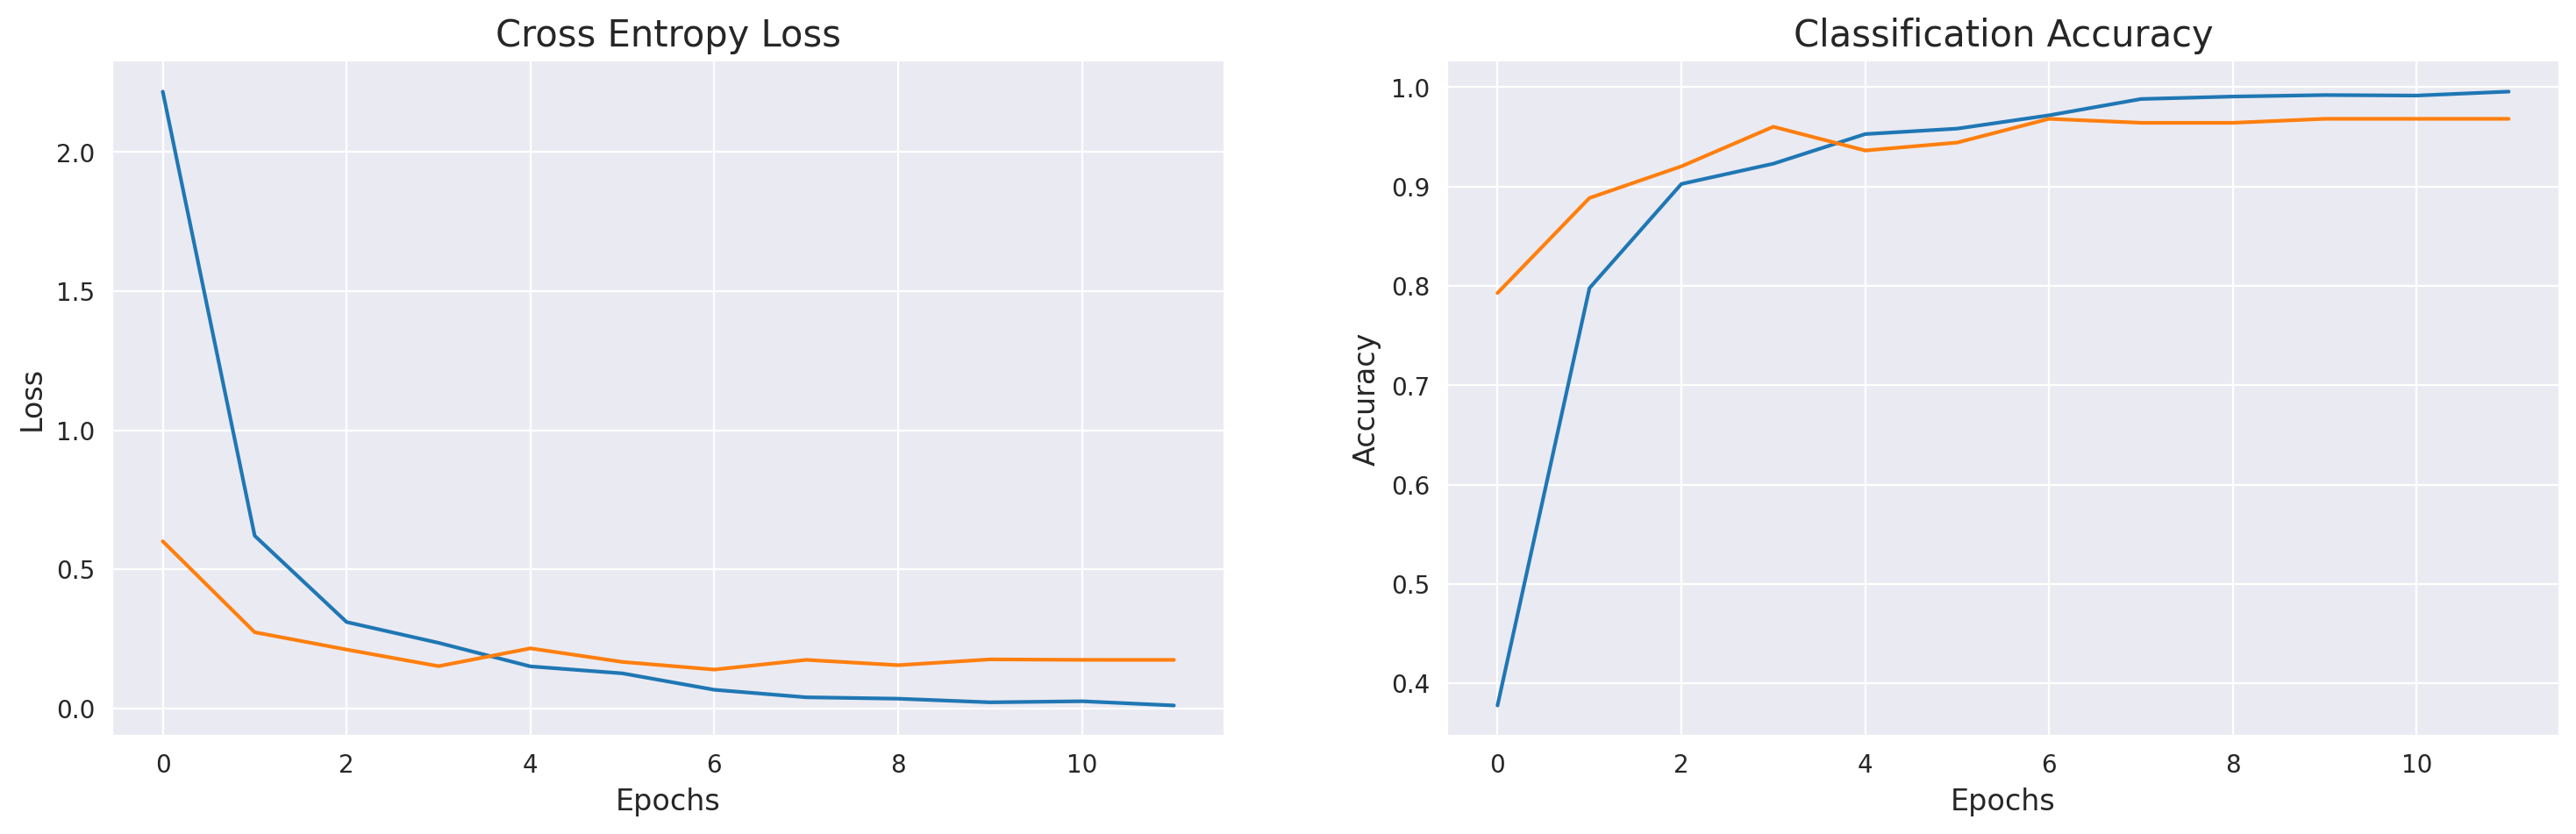

In [23]:
# plots for accuracy and Loss with epochs

error = pd.DataFrame(asl_class.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [24]:
# prediction
result = model.predict(test_data,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = test_data.labels

# Evaluvate
loss,acc = model.evaluate(test_data,verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 96.03174328804016
The Loss of the model for testing data is: 0.10263969004154205


In [25]:
p = y_pred
y = y_true
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 242
Incorrect predicted classes: 10


In [26]:
print(classification_report(y_true, y_pred,target_names= categories.values()))

              precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.88      1.00      0.93         7
           2       0.88      1.00      0.93         7
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         7
           6       0.78      1.00      0.88         7
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         7
           a       1.00      1.00      1.00         7
           b       1.00      1.00      1.00         7
           c       1.00      1.00      1.00         7
           d       1.00      1.00      1.00         7
           e       1.00      1.00      1.00         7
           f       1.00      1.00      1.00         7
           g       1.00      0.86      0.92         7
           h       1.00    

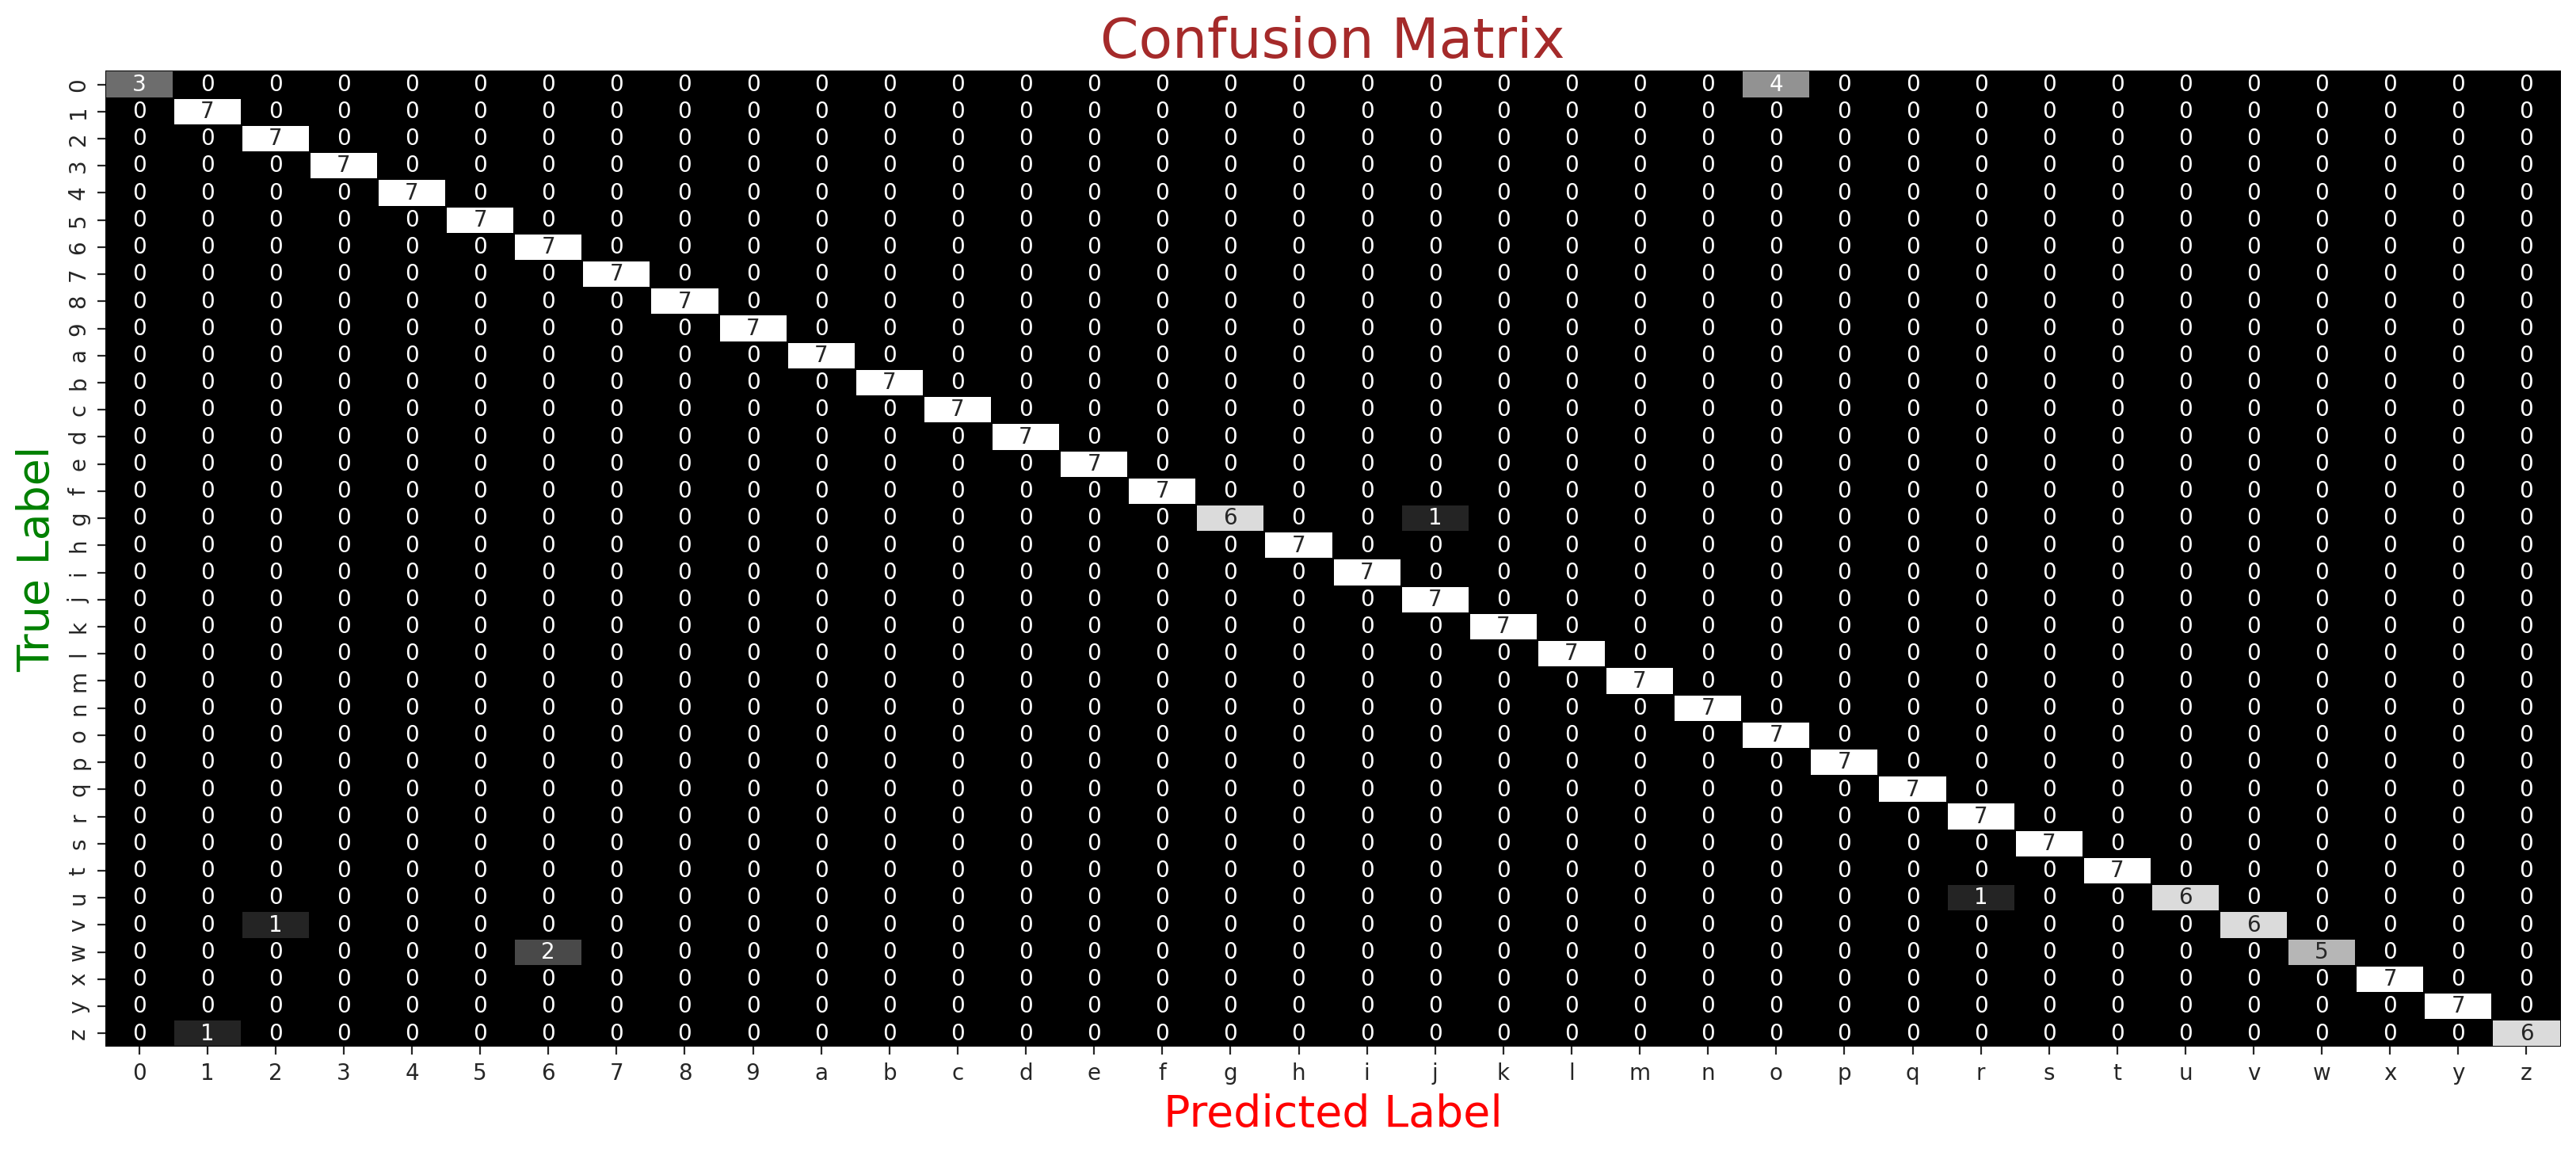

In [27]:
sns.set_style('ticks')

confusion_mtx = confusion_matrix(y_true,y_pred)

f,ax = plt.subplots(figsize = (20,8),dpi=200)

sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.1, cmap = "gist_yarg_r",
            linecolor="black", fmt='.0f', ax=ax,
            cbar=False, xticklabels=categories.values(),
            yticklabels=categories.values())

plt.xlabel("Predicted Label",fontdict={'color':'red','size':20})
plt.ylabel("True Label",fontdict={'color':'green','size':20})
plt.title("Confusion Matrix",fontdict={'color':'brown','size':25})

plt.show()